In [1]:
import numpy as np
from rashomon.hasse import enumerate_policies, enumerate_profiles, policy_to_profile
from rashomon.aggregate import RAggregate
from rashomon.metrics import find_best_policies
from rashomon.extract_pools import lattice_edges, extract_pools, aggregate_pools
from rashomon.aggregate import subset_data, find_profile_lower_bound
from rashomon.loss import compute_policy_means, compute_pool_means
import matplotlib.pyplot as plt
from rashomon.metrics import compute_all_metrics, make_predictions


## 1. Enumerate policies and profiles, build mappings

In [2]:
# ------------------------
# 1. ENUMERATE POLICIES AND PROFILES
# ------------------------
M = 3  # number of features
R = np.array([4, 3, 3])  # levels per feature


# Enumerate all policies and profiles
all_policies = enumerate_policies(M, R)
num_policies = len(all_policies)
profiles, profile_map = enumerate_profiles(M)
num_profiles = len(profiles)

# Profile index mappings (always by int index, not tuple)
policies_profiles = {}
policies_ids_profiles = {}

for k, profile in enumerate(profiles):
    # Find indices in all_policies whose profile matches this profile
    idxs = [i for i, p in enumerate(all_policies) if policy_to_profile(p) == profile]
    policies_ids_profiles[k] = idxs
    policies_profiles[k] = [all_policies[i] for i in idxs]

# Masked policies (remove baseline features for each profile)
policies_profiles_masked = {}
for k, profile in enumerate(profiles):
    profile_mask = [bool(v) for v in profile]
    masked_policies = [tuple([pol[i] for i in range(M) if profile_mask[i]]) for pol in policies_profiles[k]]
    policies_profiles_masked[k] = masked_policies

Get a safe value for H.

In [3]:
def get_max_possible_H(policies_profiles):
    """
    Returns robust (pre-allocation) max H across all profiles.
    """
    max_H = max(len(policies) for policies in policies_profiles.values())
    profile_H = {k: len(policies) for k, policies in policies_profiles.items()}
    return profile_H, max_H

# Usage:
profile_H, robust_H = get_max_possible_H(policies_profiles)
print(f"Profile-wise max pools: {profile_H}")
print(f"Robust (safe) H for experiment: {robust_H}")

H = robust_H # H is our chosen max number of pools per profile
lambda_reg = 0.1 # reg parameter
epsilon = 0.05

Profile-wise max pools: {0: 1, 1: 2, 2: 2, 3: 4, 4: 3, 5: 6, 6: 6, 7: 12}
Robust (safe) H for experiment: 12


## set up the underlying causal function and get ground truths

In [4]:
# ------------------------
# 2. DEFINE CAUSAL FUNCTION φ (policy tuple -> outcome)
# ------------------------

def phi(policy):
    """Ground truth function (edit as needed for your scenario)."""
    x = np.array(policy)
    return 2 * x[0] + 0.5 * x[1]**2 + x[0]*x[2] + 0.2 * x[1] * x[2]

In [5]:
# ------------------------
# 3. GROUND TRUTH OUTCOMES FOR EACH POLICY (NO NOISE)
# ------------------------

# Vector of ground truth means, in policy-index order
oracle_beta = np.array([phi(p) for p in all_policies])  # shape: (num_policies,)

# Top k best arms
num_top = 10

# Sorted indices of oracle_beta, descending
top_k_indices = np.argsort(oracle_beta)[-num_top:][::-1]  # highest first
print(top_k_indices)
# get info for each
top_k_policies = [all_policies[i] for i in top_k_indices]
top_k_values = oracle_beta[top_k_indices]

for rank, (idx, pol, val) in enumerate(zip(top_k_indices, top_k_policies, top_k_values), 1):
    print(f"Rank {rank}: Index {idx}, Policy {list(map(int, pol))}, Value {val}")

[35 32 29 34 26 31 28 23 25 33]
Rank 1: Index 35, Policy [3, 2, 2], Value 14.8
Rank 2: Index 32, Policy [3, 1, 2], Value 12.9
Rank 3: Index 29, Policy [3, 0, 2], Value 12.0
Rank 4: Index 34, Policy [3, 2, 1], Value 11.4
Rank 5: Index 26, Policy [2, 2, 2], Value 10.8
Rank 6: Index 31, Policy [3, 1, 1], Value 9.7
Rank 7: Index 28, Policy [3, 0, 1], Value 9.0
Rank 8: Index 23, Policy [2, 1, 2], Value 8.9
Rank 9: Index 25, Policy [2, 2, 1], Value 8.4
Rank 10: Index 33, Policy [3, 2, 0], Value 8.0


## determine boundary probabilities and allocation

In [6]:
# --- First-Wave Boundary Probability Calculation and Allocation ---
def boundary_probability(policy, R, H):
    prod = 1.0
    for i in range(len(policy)):
        vi = policy[i]
        Ri = R[i]
        numerator = 2 * min(vi, Ri - 1 - vi)
        denom = Ri - 1
        if denom == 0:
            continue
        factor = 1 - numerator / denom
        prod *= factor**(H-1)
    return 1 - prod

# TODO compare to old
def compute_boundary_probabilities(all_policies, R, H):
    """Returns an array of P(v ∈ ∂Π|H) for all policies."""
    return np.array([boundary_probability(p, R, H) for p in all_policies])


In [7]:
def get_allocations(probs, n1):
    """
    probs: array of length num_policies (boundary probabilities for each arm)
    n1: total first-wave sample size
    Returns integer allocation array (sum = n1)
    """
    total_prob = probs.sum()
    alloc_floats = n1 * probs / total_prob
    # Integer allocation: round, then correct for sum
    alloc_ints = np.floor(alloc_floats).astype(int)
    remainder = n1 - alloc_ints.sum()
    # Distribute remaining units to policies with largest fractional part
    if remainder > 0:
        frac = alloc_floats - alloc_ints
        idx_sorted = np.argsort(-frac)  # descending fractional part
        for i in idx_sorted[:remainder]:
            alloc_ints[i] += 1
    return alloc_ints

In [8]:
# --- Usage ---
n1 = 100
boundary_probs = compute_boundary_probabilities(all_policies, R, H)
alloc1 = get_allocations(boundary_probs, n1)

print(f"Total allocated: {alloc1.sum()} (should be {n1})")

Total allocated: 100 (should be 100)


## create assignments and generate data

In [9]:
# --- Generate first-wave data (assignments and observed outcomes) ---
def create_assignments_from_alloc(alloc):
    """
    Given integer allocation vector over policies, returns a (n_1, 1) array of policy indices.
    """
    D = []
    for i, count in enumerate(alloc):
        if count > 0:
            D.extend([i] * count)
    D = np.array(D, dtype=int).reshape(-1, 1)
    return D

# Use allocation from previous step:
D1 = create_assignments_from_alloc(alloc1)  # (n_1, 1)

In [10]:
def generate_data_from_assignments(D, all_policies, phi, var=1.0):
    """
    For a given list of policy indices (D), generate features X and outcomes y using phi.
    Arguments:
        D: (n, 1) array of assigned policy indices (ints from 0 to num_policies-1)
        all_policies: list of policy tuples (global)
        phi: function mapping policy tuple -> expected outcome
        var: outcome noise variance (can be scalar or array-like of same length as D)
    Returns:
        X: (n, M) array of assigned policy features
        y: (n, 1) array of outcomes
    """
    n = D.shape[0]
    X = np.zeros((n, len(all_policies[0])))
    y = np.zeros((n, 1))
    for i in range(n):
        v = all_policies[D[i, 0]]
        X[i, :] = v
        mu_i = phi(v)
        sigma_i = np.sqrt(var) if np.isscalar(var) else np.sqrt(var[D[i, 0]])
        y[i, 0] = np.random.normal(loc=mu_i, scale=sigma_i)
    return X, y

In [11]:
# Now generate X1 and y1 (features and noisy outcomes) using the assignment-based generator:
X1, y1 = generate_data_from_assignments(D1, all_policies, phi, var=1.0)

print(f"Wave 1 assignments (policy indices): {D1[:10].flatten()}")
print(f"Total n_1: {len(D1)} (should match allocation sum: {alloc1.sum()})")


Wave 1 assignments (policy indices): [1 1 1 1 3 3 3 4 4 4]
Total n_1: 100 (should match allocation sum: 100)


Print the minimum feasible value for H now that we know which profiles are observed here and which are unobserved.

In [12]:
def get_min_feasible_H(D, all_policies, profiles, policies_ids_profiles):
    """
    Returns the minimum feasible H for each profile (dict),
    and the global max across all observed profiles.
    """
    unique_policies_per_profile = {}
    for k in policies_ids_profiles:
        idxs = set(policies_ids_profiles[k])
        # Which units in D are assigned to profile k?
        mask = np.isin(D.flatten(), list(idxs))
        observed = D[mask].flatten() if np.any(mask) else []
        num_unique = len(np.unique(observed))
        unique_policies_per_profile[k] = num_unique
    global_H = max(unique_policies_per_profile.values())
    return unique_policies_per_profile, global_H

# Example usage (after D1 is constructed):
unique_policies, min_H = get_min_feasible_H(D1, all_policies, profiles, policies_ids_profiles)
print(f"Unique policies per profile: {unique_policies}")
print(f"Set H >= {min_H} for feasibility.")

Unique policies per profile: {0: 0, 1: 1, 2: 1, 3: 3, 4: 2, 5: 5, 6: 5, 7: 11}
Set H >= 11 for feasibility.


## Enumerate RPS

In [13]:
# --- 1. Prepare mappings for profile subsetting ---

# Recall: policies_profiles[k] = list of policies for profile k
#         policies_ids_profiles[k] = list of global indices for those policies

def subset_wave_data_by_profile(D1, y1, all_policies, profiles, policies_ids_profiles):
    """
    For each profile, subset D1/y1 to only units assigned to this profile.
    Returns:
        D1_profiles: dict k -> (n_k, 1) policy indices (profile-local, 0-based)
        y1_profiles: dict k -> (n_k, 1) outcomes
        global_to_local: dict k -> dict mapping global policy idx to profile-local idx
    """
    D1_profiles = {}
    y1_profiles = {}
    global_to_local = {}
    for k, idxs in policies_ids_profiles.items():
        # Build set for fast membership
        idxs_set = set(idxs)
        # Mask: which units in D1 assigned to this profile?
        mask = np.array([d[0] in idxs_set for d in D1])
        if not np.any(mask):
            continue  # no data for this profile
        D1_k = D1[mask].flatten()
        y1_k = y1[mask]
        # Remap global indices to profile-local (as expected by RAggregate)
        glob2loc = {glob: loc for loc, glob in enumerate(idxs)}
        D1_k_profile = np.array([glob2loc[d] for d in D1_k]).reshape(-1, 1)
        D1_profiles[k] = D1_k_profile
        y1_profiles[k] = y1_k
        global_to_local[k] = glob2loc
    return D1_profiles, y1_profiles, global_to_local

In [14]:
# --- 2. Compute policy means for each profile ---

def compute_profile_policy_means(D1_profiles, y1_profiles, policies_profiles):
    """
    For each profile, compute policy means/counts.
    Returns: dict k -> policy_means (num_policies_in_profile, 2)
    """
    profile_policy_means = {}
    for k in D1_profiles.keys():
        n_policies = len(policies_profiles[k])
        pm = compute_policy_means(D1_profiles[k], y1_profiles[k], n_policies)
        profile_policy_means[k] = pm
    return profile_policy_means

In [15]:
def build_global_wave_data(D1_profiles, y1_profiles, policies_profiles, profiles, policies_ids_profiles):
    """
    Stacks all observed profiles into arrays for RAggregate.
    Critically: converts local profile indices back to global indices using policies_ids_profiles.
    Returns D1_full (global indices), y1_full
    """
    D_list, y_list = [], []
    for k in D1_profiles.keys():
        idxs = policies_ids_profiles[k]
        D1_k_profile = D1_profiles[k].flatten()
        # Map each local index back to its global policy index for this profile
        D1_k_global = np.array([idxs[local_idx] for local_idx in D1_k_profile]).reshape(-1, 1)
        D_list.append(D1_k_global)
        y_list.append(y1_profiles[k])
    D1_full = np.vstack(D_list)
    y1_full = np.vstack(y_list)
    return D1_full, y1_full

In [16]:
# --- Run RAggregate (Global RPS Construction) ---

def construct_RPS_basic(M, R, H, D1, y1, theta, reg=0.001, num_workers=1, verbose=False):
    """
    Calls RAggregate to enumerate Rashomon sets for observed profiles, given all data.
    """
    R_set, R_profiles = RAggregate(M, R, H, D1, y1, theta, reg=reg, num_workers=num_workers, verbose=verbose)
    return R_set, R_profiles

In [17]:
def find_top_k_policies(D, y_pred, k):
    idx_sorted = np.argsort(-y_pred.flatten())
    D_flat = D.flatten()[idx_sorted]
    _, unique_idx = np.unique(D_flat, return_index=True)
    top_k = D_flat[np.sort(unique_idx)][:k]
    return top_k

In [25]:
def construct_RPS_adaptive(
    M, R, H, D_full, y_full, num_top, policies_profiles_masked, policies_ids_profiles,
    profiles, all_policies, top_k_indices,
    theta_init,  # precomputed lower bound or baseline theta
    reg=0.1, max_factor=2.0, step_ratio=5, verbose=True,
    adaptive=False,  # pass if already computed for efficiency
    recovery_type="arm"  # "arm" (policy index) or "profile"
):
    # TODO later will need to remove the top_k_indices argumetn to make this usable without oracle. Just for interpretation right now.
    """
    Adaptive Rashomon set construction:
    Increments theta until RPS contains a partition whose best arm(s)
    (or profile) include the oracle-best.

    Returns:
        R_set, R_profiles, theta, found, theta_trace, rps_size_trace,
        per_partition: dict of lists (all same len = Rashomon set size), including:
            - best_pred_indices (top-k for each partition)
            - best_pred_profiles
            - regret (oracle minus predicted mean)
            - pool_means_r (per-partition policy means)
            - y_r_est (per-partition predictions)
            - pool_assignments (policy -> pool id mapping)
            - total_loss (loss for this partition)
    """

    theta = theta_init
    theta_step = theta_init / step_ratio
    max_theta = theta_init * max_factor
    found = False
    iteration = 0
    theta_trace = []
    rps_size_trace = []

    # True best policies/profiles
    if recovery_type == "profile":
        best_targets = set(policy_to_profile(all_policies[idx]) for idx in top_k_indices)
    else:
        best_targets = set(top_k_indices)

    from rashomon.loss import compute_policy_means
    policy_means = compute_policy_means(D_full, y_full, len(all_policies))


    while not found and theta <= max_theta:
        if verbose and adaptive:
            print(f"Trying theta={theta:.6f}")
        R_set, R_profiles = RAggregate(
            M, R, H, D_full, y_full, theta, reg=reg, num_workers=1, verbose=verbose
        )
        theta_trace.append(theta)
        rps_size_trace.append(len(R_set))
        if len(R_set) == 0:
            theta += theta_step * theta_init
            iteration += 1
            continue

        # For each partition in the Rashomon set, check recovery
        for r_set in R_set:
            # Assign pools for each profile
            pi_policies_profiles_r = {}
            for k, profile in enumerate(profiles):
                if len(R_profiles[k]) == 0:
                    continue
                sigma_k = R_profiles[k].sigma[r_set[k]]
                if sigma_k is None:
                    n_policies_profile = len(policies_profiles_masked[k])
                    pi_policies_r_k = {i: 0 for i in range(n_policies_profile)}
                else:
                    _, pi_policies_r_k = extract_pools(
                        policies_profiles_masked[k], sigma_k)
                pi_policies_profiles_r[k] = pi_policies_r_k

            pi_pools_r, pi_policies_r = aggregate_pools(
                pi_policies_profiles_r, policies_ids_profiles)
            pool_means_r = compute_pool_means(policy_means, pi_pools_r)
            y_r_est = make_predictions(D_full, pi_policies_r, pool_means_r)
            best_pred_indices = find_top_k_policies(D_full, y_r_est, num_top)

            if recovery_type == "profile":
                # Did any predicted-best policy match a best profile?
                found_profiles = set(policy_to_profile(all_policies[idx]) for idx in best_pred_indices)
                if best_targets & found_profiles:
                    found = True
                    if verbose:
                        print("----FOUND-----")
                        print("actual best profile(s): ", best_targets)
                        print("found profile(s): ", found_profiles)
                    break
            else:  # "arm"
                if best_targets & set(best_pred_indices):
                    found = True
                    if verbose:
                        print("----FOUND-----")
                        print("actual best arms: ", [int(x) for x in best_targets])
                        print("best predicted arms: ", [int(x) for x in set(best_pred_indices)])
                    break

        if verbose:
            print("Size of RPS", len(R_set))
        if adaptive == False:
            break
        if not found:
            theta += theta_step * theta_init
            iteration += 1

    if adaptive and not found:
        print(f"Warning: max_theta reached without finding a Rashomon partition covering the best {recovery_type}.")
    if adaptive and verbose:
        print(f"Final theta for RPS: {theta:.4f} (after {iteration} iterations)")

    return R_set, R_profiles, theta, found, theta_trace, rps_size_trace

In [26]:
# 1. Subset D1, y1 by profile and remap indices
D1_profiles, y1_profiles, global_to_local = subset_wave_data_by_profile(
    D1, y1, all_policies, profiles, policies_ids_profiles
)

In [27]:
# 2. Compute per-profile policy means
profile_policy_means = compute_profile_policy_means(D1_profiles, y1_profiles, policies_profiles)

# Which profile has highest observed mean?
for k in profile_policy_means:
    pm = profile_policy_means[k]
    means = pm[:,0] / np.maximum(pm[:,1], 1)
    print(f"Profile {k}: Max observed mean = {means.max():.3f}")

Profile 1: Max observed mean = 0.000
Profile 2: Max observed mean = 1.023
Profile 3: Max observed mean = 2.489
Profile 4: Max observed mean = 3.973
Profile 5: Max observed mean = 9.227
Profile 6: Max observed mean = 6.828
Profile 7: Max observed mean = 12.918


In [28]:
# 3. Stack all observed units for global RAggregate (this stacks D1/y1 for all observed profiles)
D1_full, y1_full = build_global_wave_data(D1_profiles, y1_profiles, policies_profiles, profiles, policies_ids_profiles)

In [29]:
# get lower bound for theta
profile_lower_bounds = []
for k, profile in enumerate(profiles):
    Dk, yk = subset_data(D1_full, y1_full, policies_ids_profiles[k])
    if Dk is None:
        continue
    n_policies_k = len(policies_profiles[k])
    pm = compute_policy_means(Dk, yk, n_policies_k)
    profile_lb = find_profile_lower_bound(Dk, yk, pm)
    profile_lower_bounds.append(profile_lb)
theta_global = sum(profile_lower_bounds) * (1+epsilon)
print("theta_global: ", theta_global)

theta_global:  63.692351425727345


In [30]:
k = 7  # profile index for (1,1,1)
print("Profile 7: policy indices (global)", policies_ids_profiles[k])
print("Profile 7: number of unique observed policies:", len(np.unique(D1.flatten()[np.isin(D1.flatten(), policies_ids_profiles[k])])))

Profile 7: policy indices (global) [13, 14, 16, 17, 22, 23, 25, 26, 31, 32, 34, 35]
Profile 7: number of unique observed policies: 11


In [31]:
# OPTION 1-----
# R_set_other, R_profiles_other = construct_RPS(M, R, H, D1_full, y1_full, theta_global, reg=lambda_reg, num_workers=1, verbose=True)

# OPTION 2 -----  Run the adaptive Rashomon constructor:
R_set, R_profiles, theta_final, found_best, theta_trace, rps_size_trace = construct_RPS_adaptive(
    M, R, H, D1_full, y1_full, num_top, policies_profiles_masked, policies_ids_profiles, profiles, all_policies, top_k_indices, theta_global, reg=lambda_reg, adaptive=False, verbose=True, recovery_type = "arm"
)

Skipping profile (0, 0, 0)
(0, 0, 1) 63.0892459985186
Adaptive
Profile (0, 0, 1) took 0.0007312297821044922 s adaptively
Profile (0, 0, 1) has 2 objects in Rashomon set
(0, 1, 0) 63.095361713526415
Adaptive
Profile (0, 1, 0) took 0.0004260540008544922 s adaptively
Profile (0, 1, 0) has 2 objects in Rashomon set
(0, 1, 1) 63.13317562897486
Adaptive
Profile (0, 1, 1) took 0.0011301040649414062 s adaptively
Profile (0, 1, 1) has 4 objects in Rashomon set
(1, 0, 0) 63.200898521281694
Adaptive
Profile (1, 0, 0) took 0.0009899139404296875 s adaptively
Profile (1, 0, 0) has 4 objects in Rashomon set
(1, 0, 1) 63.13797887762822
Adaptive
Profile (1, 0, 1) took 0.003239154815673828 s adaptively
Profile (1, 0, 1) has 8 objects in Rashomon set
(1, 1, 0) 63.24380959996524
Adaptive
Profile (1, 1, 0) took 0.0037207603454589844 s adaptively
Profile (1, 1, 0) has 8 objects in Rashomon set
(1, 1, 1) 63.3064267015834
Adaptive
Profile (1, 1, 1) took 0.009942054748535156 s adaptively
Profile (1, 1, 1) has 

In [32]:
print("Top-k best policies and their profiles:")
for rank, idx in enumerate(top_k_indices, 1):
    policy = all_policies[idx]
    profile = policy_to_profile(policy)
    print(f"Rank {rank}: Policy idx {idx}, Policy {[int(i) for i in policy]}, Profile {profile}")
# 3. Inspect the results
print(f"Adaptive RPS size: {len(R_set)}")
print(f"Final theta used: {theta_final:.4f}")
if found_best:
    print("Rashomon set contains a partition that recovers at least one oracle-best arm.")
else:
    print("Warning: No Rashomon partition found with an oracle-best arm within threshold.")

Top-k best policies and their profiles:
Rank 1: Policy idx 35, Policy [3, 2, 2], Profile (1, 1, 1)
Rank 2: Policy idx 32, Policy [3, 1, 2], Profile (1, 1, 1)
Rank 3: Policy idx 29, Policy [3, 0, 2], Profile (1, 0, 1)
Rank 4: Policy idx 34, Policy [3, 2, 1], Profile (1, 1, 1)
Rank 5: Policy idx 26, Policy [2, 2, 2], Profile (1, 1, 1)
Rank 6: Policy idx 31, Policy [3, 1, 1], Profile (1, 1, 1)
Rank 7: Policy idx 28, Policy [3, 0, 1], Profile (1, 0, 1)
Rank 8: Policy idx 23, Policy [2, 1, 2], Profile (1, 1, 1)
Rank 9: Policy idx 25, Policy [2, 2, 1], Profile (1, 1, 1)
Rank 10: Policy idx 33, Policy [3, 2, 0], Profile (1, 1, 0)
Adaptive RPS size: 4085
Final theta used: 63.6924
Rashomon set contains a partition that recovers at least one oracle-best arm.


In [33]:
# Gather observed policy indices (in wave 1)
observed_policy_indices = set(D1.flatten())
# Gather observed profiles (in wave 1)
observed_profiles = set()
for idx in observed_policy_indices:
    prof = policy_to_profile(all_policies[idx])
    observed_profiles.add(prof)

print("\nObserved profiles in data:", observed_profiles)
print("Are all top-k best profiles observed?")

for rank, idx in enumerate(top_k_indices, 1):
    policy = all_policies[idx]
    prof = policy_to_profile(policy)
    print(f"Best Policy {idx}: Profile {prof}, Observed? {prof in observed_profiles}")


Observed profiles in data: {(1, 0, 1), (1, 1, 0), (0, 1, 0), (1, 0, 0), (0, 0, 1), (1, 1, 1), (0, 1, 1)}
Are all top-k best profiles observed?
Best Policy 35: Profile (1, 1, 1), Observed? True
Best Policy 32: Profile (1, 1, 1), Observed? True
Best Policy 29: Profile (1, 0, 1), Observed? True
Best Policy 34: Profile (1, 1, 1), Observed? True
Best Policy 26: Profile (1, 1, 1), Observed? True
Best Policy 31: Profile (1, 1, 1), Observed? True
Best Policy 28: Profile (1, 0, 1), Observed? True
Best Policy 23: Profile (1, 1, 1), Observed? True
Best Policy 25: Profile (1, 1, 1), Observed? True
Best Policy 33: Profile (1, 1, 0), Observed? True


In [34]:
for k, rprof in enumerate(R_profiles):
    print(f"Profile {k}: {len(rprof)} poolings in RPS (if observed)")
print(f"First-wave Rashomon set: {len(R_set)} feasible global partitions (combinations of per-profile poolings).")
# You now have R_set (list of feasible global partition indices) and R_profiles (list of per-profile RashomonSets)

Profile 0: 1 poolings in RPS (if observed)
Profile 1: 2 poolings in RPS (if observed)
Profile 2: 2 poolings in RPS (if observed)
Profile 3: 4 poolings in RPS (if observed)
Profile 4: 4 poolings in RPS (if observed)
Profile 5: 8 poolings in RPS (if observed)
Profile 6: 8 poolings in RPS (if observed)
Profile 7: 13 poolings in RPS (if observed)
First-wave Rashomon set: 4085 feasible global partitions (combinations of per-profile poolings).


f#### (optional) can look at plots of size, epsilon, and loss

Some plots after the first construction of the RPS to look at RPS size and epsilon, and the error distribution:

In [35]:
def plot_rps_size_vs_epsilon(aggregate_func, M, R, H, D1_full, y1_full, base_theta, reg=1e-5, epsilons=None):
    """
    Plots RPS size vs epsilon. aggregate_func = RAggregate or similar.
    """
    if epsilons is None:
        epsilons = np.linspace(0.01, 0.2, 10)  # sweep from 1% to 20% above min loss
    set_sizes = []
    min_loss = None
    for eps in epsilons:
        theta = base_theta * (1 + eps)
        R_set, R_profiles = aggregate_func(M, R, H, D1_full, y1_full, theta, reg=reg)
        set_sizes.append(len(R_set))
        # Find MAP (min loss) if needed
        if min_loss is None and len(R_set) > 0:
            # Min loss over all models in this set
            min_loss = min(
                sum(R_profiles[k].loss[r[profile]] for k, profile in enumerate(r))
                for r in R_set
            )
    plt.figure(figsize=(6, 4))
    plt.plot(epsilons, set_sizes, marker='o')
    plt.xlabel(r'$\epsilon$')
    plt.ylabel('Rashomon Set Size')
    plt.title('RPS Size vs. Loss Tolerance')
    plt.axvline(x=0.05, color='r', linestyle='--', label='Baseline epsilon')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Usage after constructing D1_full, y1_full:
# plot_rps_size_vs_epsilon(RAggregate, M, R, H, D1_full, y1_full, theta_global, reg=1e-5)

In [36]:
def plot_rps_loss_histogram(R_set, R_profiles):
    """
    Plot histogram of losses across Rashomon set (sum over profiles).
    """
    if len(R_set) == 0:
        print("Empty Rashomon set.")
        return
    losses = []
    for r in R_set:
        total_loss = sum(R_profiles[k].loss[r[k]] for k in range(len(r)))
        losses.append(total_loss)
    plt.figure(figsize=(6, 4))
    plt.hist(losses, bins=20, color='dodgerblue', alpha=0.7)
    plt.axvline(min(losses), color='r', linestyle='--', label='MAP loss')
    plt.xlabel('Total Loss')
    plt.ylabel('Count')
    plt.title('Loss Distribution in RPS')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Usage:
# plot_rps_loss_histogram(R_set, R_profiles)

In [37]:
# plot_rps_size_vs_epsilon(RAggregate, M, R, H, D1_full, y1_full, theta_global, reg=lambda_reg)

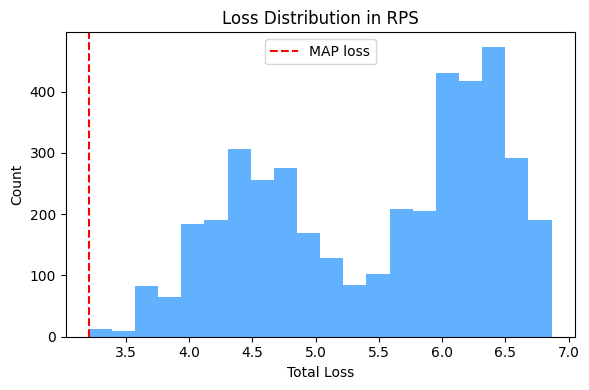

In [38]:
plot_rps_loss_histogram(R_set, R_profiles)

## get second wave boundary probabilities and allocation

In [39]:
def get_policy_neighbors(all_policies):
    """
    Uses lattice_edges helper to get neighbor map for policies.
    """
    edges = lattice_edges(all_policies)  # list of (i, j)
    neighbors = {i: [] for i in range(len(all_policies))}
    for i, j in edges:
        neighbors[i].append(j)
        neighbors[j].append(i)  # edges are undirected
    return neighbors

# Usage:
# neighbors = get_policy_neighbors_from_edges(all_policies)

In [40]:
def compute_global_boundary_matrix(
    R_set, R_profiles, neighbors, profiles, policies_profiles_masked, policies_ids_profiles, all_policies
):
    """
    Returns boundary_matrix: shape (n_partitions, num_policies)
    boundary_matrix[j, i] = number of boundaries for policy i in partition j
    (i.e., number of neighbors in a different pool)
    """
    num_policies = len(all_policies)
    n_partitions = len(R_set)

    boundary_matrix = np.zeros((n_partitions, num_policies), dtype=int)

    for j, r in enumerate(R_set):
        pi_policies_profiles_r = {}
        for k, profile in enumerate(profiles):
            if len(R_profiles[k]) == 0:
                continue
            sigma_k = R_profiles[k].sigma[r[k]]
            if sigma_k is None:
                continue
            _, pi_policies_k = extract_pools(policies_profiles_masked[k], sigma_k)
            pi_policies_profiles_r[k] = pi_policies_k
        pi_pools_r, pi_policies_r = aggregate_pools(pi_policies_profiles_r, policies_ids_profiles)
        for i in range(num_policies):
            pool_i = pi_policies_r.get(i, -1)
            if pool_i == -1:
                continue
            # Count number of neighbors in a different pool
            count = 0
            for nb in neighbors[i]:
                pool_nb = pi_policies_r.get(nb, -1)
                if pool_nb != -1 and pool_nb != pool_i:
                    count += 1
            boundary_matrix[j, i] = count
    return boundary_matrix

In [41]:
def get_posterior_weights(R_set, R_profiles):

    losses = np.array([sum(R_profiles[k].loss[r[k]] for k in range(len(r))) for r in R_set])
    weights = np.exp(-losses)
    weights /= weights.sum() if weights.sum() > 0 else 1.0

    return weights

In [42]:
neighbors = get_policy_neighbors(all_policies)

In [43]:
boundary_matrix = compute_global_boundary_matrix(R_set, R_profiles, neighbors, profiles, policies_profiles_masked, policies_ids_profiles, all_policies)
binary_boundary_matrix = (boundary_matrix > 0).astype(float)


In [44]:
posterior_weights = get_posterior_weights(R_set, R_profiles)

In [45]:
# Weighted average across partitions
posterior_boundary_probs = np.average(binary_boundary_matrix, axis=0, weights=posterior_weights)
# posterior_weighted_boundary_probs[i]: average number of boundaries for policy i, weighted by RPS posterior
# Usage:
posterior_boundary_probs = np.round(posterior_boundary_probs, decimals=8)


In [46]:
# 1. Basic shape check
assert posterior_boundary_probs.shape == (len(all_policies),), "Posterior vector shape mismatch"

# 2. Check range and sum
print("Posterior boundary min/max:", posterior_boundary_probs.min(), posterior_boundary_probs.max())
# 3. Check for degenerate values
assert np.all((posterior_boundary_probs >= 0) & (posterior_boundary_probs <= 1)), "Probabilities out of bounds"

Posterior boundary min/max: 0.0 1.0


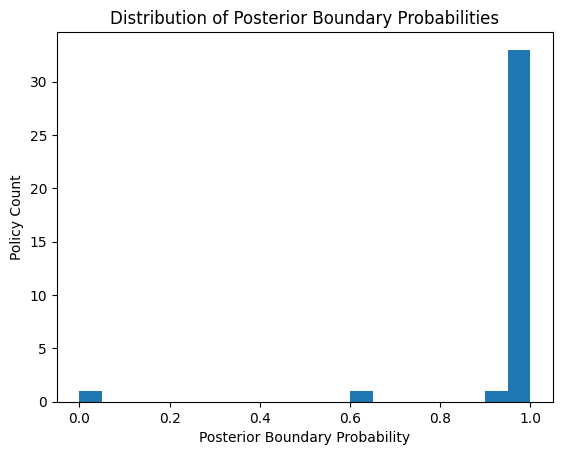

In [47]:
# Visualize the distribution
plt.hist(posterior_boundary_probs, bins=20)
plt.xlabel('Posterior Boundary Probability')
plt.ylabel('Policy Count')
plt.title('Distribution of Posterior Boundary Probabilities')
plt.show()

## Next waves

In [48]:
# Set n2 (second-wave sample size, e.g., same as n1 or a new value)
n2 = 100

# posterior_boundary_probs: already computed above, vector of length num_policies
# Use the same allocation function as for wave 1
alloc2 = get_allocations(posterior_boundary_probs, n2)

print(f"Second-wave allocations (first 10): {alloc2[:10]}")
print(f"Total allocated: {alloc2.sum()} (should be {n2})")

Second-wave allocations (first 10): [0 3 3 3 3 3 3 3 3 3]
Total allocated: 100 (should be 100)


In [49]:
# Assignments (policy indices) for wave 2
D2 = create_assignments_from_alloc(alloc2)  # (n2, 1)

# Generate new features and outcomes for wave 2
X2, y2 = generate_data_from_assignments(D2, all_policies, phi, var=1.0)

print(f"Wave 2 assignments (policy indices): {D2[:10].flatten()}")
print(f"Wave 2 features X2: {X2[:5, :]}")
print(f"Wave 2 outcomes y2: {y2[:5, 0]}")
print(f"Total n_2: {len(D2)} (should match allocation sum: {alloc2.sum()})")

Wave 2 assignments (policy indices): [1 1 1 2 2 2 3 3 3 4]
Wave 2 features X2: [[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 2.]
 [0. 0. 2.]]
Wave 2 outcomes y2: [ 0.25222654  0.98226641  0.27353614 -0.07203657 -0.74619978]
Total n_2: 100 (should match allocation sum: 100)


## construct updated RPS

In [50]:
# --- Combine data for both waves ---
D_total = np.vstack([D1, D2])
y_total = np.vstack([y1, y2])

# --- Subset and remap ---
D_total_profiles, y_total_profiles, global_to_local_total = subset_wave_data_by_profile(
    D_total, y_total, all_policies, profiles, policies_ids_profiles
)

profile_policy_means_total = compute_profile_policy_means(D_total_profiles, y_total_profiles, policies_profiles)

# --- Stack all observed units into D_total_full, y_total_full (global indices) ---
D_total_full, y_total_full = build_global_wave_data(
    D_total_profiles, y_total_profiles, policies_profiles, profiles, policies_ids_profiles
)

In [51]:
# --- Get profile lower bounds and global theta ---
profile_lower_bounds_total = []
for k in D_total_profiles:
    Dk, yk = subset_data(D_total_full, y_total_full, policies_ids_profiles[k])
    if Dk is None:
        continue
    n_policies_k = len(policies_profiles[k])
    pm = compute_policy_means(Dk, yk, n_policies_k)
    profile_lb = find_profile_lower_bound(Dk, yk, pm)
    profile_lower_bounds_total.append(profile_lb)
theta_global_total = sum(profile_lower_bounds_total) * (1.05)  # adjust epsilon as needed

print("theta_global (final): ", theta_global_total) # TODO should we be updating the threshold for each wave??

theta_global (final):  175.3200790016132


In [52]:
# --- Run Rashomon set construction as in first wave ---
R_set_total, R_profiles_total, theta_final, found_best, theta_trace, rps_size_trace = construct_RPS_adaptive(
    M, R, H, D_total_full, y_total_full, num_top, policies_profiles_masked, policies_ids_profiles,
    profiles, all_policies, top_k_indices, theta_global_total, reg=lambda_reg, adaptive=False, verbose=True, recovery_type="arm"
)

print(f"Final Rashomon set: {len(R_set_total)} feasible global partitions (with all data).")
for k, rprof in enumerate(R_profiles_total):
    print(f"Profile {k}: {len(rprof)} poolings in RPS (if observed)")

Skipping profile (0, 0, 0)
(0, 0, 1) 174.49515084414872
Adaptive
Profile (0, 0, 1) took 0.0007131099700927734 s adaptively
Profile (0, 0, 1) has 2 objects in Rashomon set
(0, 1, 0) 174.5247542003473
Adaptive
Profile (0, 1, 0) took 0.0004229545593261719 s adaptively
Profile (0, 1, 0) has 2 objects in Rashomon set
(0, 1, 1) 174.56616330232904
Adaptive
Profile (0, 1, 1) took 0.0013120174407958984 s adaptively
Profile (0, 1, 1) has 4 objects in Rashomon set
(1, 0, 0) 174.57272290060556
Adaptive
Profile (1, 0, 0) took 0.0009589195251464844 s adaptively
Profile (1, 0, 0) has 4 objects in Rashomon set
(1, 0, 1) 174.6217744990338
Adaptive
Profile (1, 0, 1) took 0.003292083740234375 s adaptively
Profile (1, 0, 1) has 8 objects in Rashomon set
(1, 1, 0) 174.64868464898413
Adaptive
Profile (1, 1, 0) took 0.003774881362915039 s adaptively
Profile (1, 1, 0) has 8 objects in Rashomon set
(1, 1, 1) 174.80215750151208
Adaptive
Profile (1, 1, 1) took 0.010095834732055664 s adaptively
Profile (1, 1, 1) 

In [53]:
# Compute boundary masks/probabilities as before for both waves:
boundary_matrix_1 = compute_global_boundary_matrix(R_set, R_profiles, neighbors, profiles, policies_profiles_masked, policies_ids_profiles, all_policies)
binary_boundary_matrix_1 = (boundary_matrix_1 > 0).astype(float)

posterior_boundary_probs_1 = np.average(binary_boundary_matrix_1, axis=0, weights=get_posterior_weights(R_set, R_profiles))

boundary_matrix_2 = compute_global_boundary_matrix( R_set_total, R_profiles_total, neighbors, profiles, policies_profiles_masked, policies_ids_profiles, all_policies)
binary_boundary_matrix_2 = (boundary_matrix_2 > 0).astype(float)

posterior_boundary_probs_2 = np.average(binary_boundary_matrix_2, axis=0, weights=get_posterior_weights(R_set_total, R_profiles_total))

# Compare statistics:
diff = posterior_boundary_probs_2 - posterior_boundary_probs_1
print("Number of policies with DECREASED boundary probability:", (diff < -0.0001).sum())
print("Number of policies with INCREASED boundary probability:", (diff > 0.0001).sum())
print("Mean change in boundary probability:", diff.mean())
print("Fraction of policies now at 0 boundary probability:", (posterior_boundary_probs_2 < 1e-8).mean())
print("Fraction now at 1 boundary probability:", (posterior_boundary_probs_2 > 1 - 1e-8).mean())


Number of policies with DECREASED boundary probability: 2
Number of policies with INCREASED boundary probability: 0
Mean change in boundary probability: -0.0009463826144299809
Fraction of policies now at 0 boundary probability: 0.027777777777777776
Fraction now at 1 boundary probability: 0.9166666666666666


In [55]:
for idx in np.argsort(-np.abs(diff))[:10]:
    print(f"Policy {idx} {all_policies[idx]}: wave1={posterior_boundary_probs_1[idx]:.3f}, wave2={posterior_boundary_probs_2[idx]:.3f}, delta={diff[idx]:.10f}")


Policy 35 (np.int64(3), np.int64(2), np.int64(2)): wave1=0.613, wave2=0.587, delta=-0.0255278993
Policy 26 (np.int64(2), np.int64(2), np.int64(2)): wave1=0.912, wave2=0.904, delta=-0.0085418748
Policy 32 (np.int64(3), np.int64(1), np.int64(2)): wave1=1.000, wave2=1.000, delta=0.0000000000
Policy 31 (np.int64(3), np.int64(1), np.int64(1)): wave1=1.000, wave2=1.000, delta=0.0000000000
Policy 30 (np.int64(3), np.int64(1), np.int64(0)): wave1=1.000, wave2=1.000, delta=0.0000000000
Policy 29 (np.int64(3), np.int64(0), np.int64(2)): wave1=1.000, wave2=1.000, delta=0.0000000000
Policy 28 (np.int64(3), np.int64(0), np.int64(1)): wave1=1.000, wave2=1.000, delta=0.0000000000
Policy 27 (np.int64(3), np.int64(0), np.int64(0)): wave1=1.000, wave2=1.000, delta=0.0000000000
Policy 19 (np.int64(2), np.int64(0), np.int64(1)): wave1=1.000, wave2=1.000, delta=0.0000000000
Policy 25 (np.int64(2), np.int64(2), np.int64(1)): wave1=1.000, wave2=1.000, delta=0.0000000000


## Regret and Evaluation

In [56]:
policy_means_total = compute_policy_means(D_total, y_total, num_policies)